<a href="https://colab.research.google.com/github/crisouzajr/Deep-Learning-Projects/blob/Stock-Price-Prediction-(GRU-x-LSTM)/GRU_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM e GRU para prever o preço das ações da IBM 

## A base de dados original contem um histórico entre os anos de 2006 a 2017, logo, será a base para prever um intervalo específico de meses antes do encerramento do ano de 2017.

## Importando as bibliotecas necessárias ao estudo.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

## Funções para plotagem

In [ ]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real IBM Stock Price')
    plt.plot(predicted, color='blue',label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('IBM Stock Price')
    plt.legend()
    plt.show()
    

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("O resultado de RMSE é {}.".format(rmse))

# Conhecendo a base de dados

In [ ]:
""" Visualizando as duas primeiras linhas da base."""

dataset = pd.read_csv('IBM_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
dataset.head(2)

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM


In [ ]:
""" Visualizando as duas últimas linhas da base."""

dataset.tail(2)

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2017-12-28,153.20,154.12,153.20,154.04,2687624,IBM
2017-12-29,154.17,154.72,153.42,153.42,3327087,IBM


In [ ]:
len(dataset)

3020

## Escolhendo o atributo 'ALTA' para os preços das ações, e então decidir entre as opções de compra ou venda.

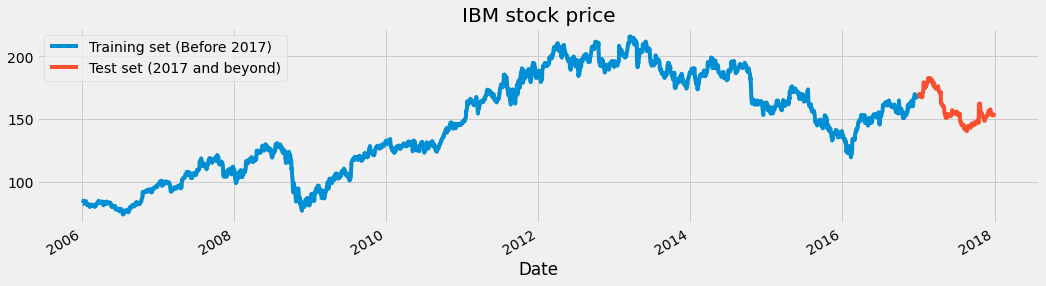

In [ ]:
""" Série temporal para as ALTAS das ações"""

training_set = dataset[:'2016'].iloc[:,1:2].values
test_set = dataset['2017':].iloc[:,1:2].values



dataset["High"][:'2016'].plot(figsize=(16,4),legend=True)
dataset["High"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('IBM stock price')
plt.show()

# Escalonando o conjunto de treinamento com todos os dados.

A ideia é reter a informação, armazenado a memória a cada 60 valores novos.

* Os LSTMs armazenam o estado da memória de longo prazo. 

* Criamos então uma estrutura de dados com 60 passos de tempo e 1 saída.

* Para cada elemento do conjunto de treinamento, temos 60 elementos do conjunto de treinamento anterior.

In [ ]:
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)


X_train = []
y_train = []

for i in range(20,2769):
    X_train.append(training_set_scaled[i-20:i,0])
    y_train.append(training_set_scaled[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)

### Remodelando X_train para modelagem eficiente

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

# LSTM 

A LSTM é uma arquitetura de rede neural recorrente (RNN) que “lembra” valores em intervalos arbitrários. A LSTM é bem adequada para classificar, processar e prever séries temporais com intervalos de tempo de duração desconhecida. A insensibilidade relativa ao comprimento do gap dá uma vantagem à LSTM em relação a RNNs tradicionais (também chamadas “vanilla”), Modelos Ocultos de Markov (MOM) e outros métodos de aprendizado de sequências.

A estrutura de uma RNN é muito semelhante ao Modelo Oculto de Markov. No entanto, a principal diferença é como os parâmetros são calculados e construídos. Uma das vantagens da LSTM é a insensibilidade ao comprimento do gap. RNN e MOM dependem do estado oculto antes da emissão / sequência. Se quisermos prever a sequência após 1.000 intervalos em vez de 10, o modelo esqueceu o ponto de partida até então. Mas um modelo LSTM é capaz de “lembrar” por conta de sua estrutura de células, o diferencial da arquitetura LSTM.

# Arquitetura da LSTM

In [ ]:
regressor = Sequential()

# Primeira camada de LSTM sem o regularizador Dropout
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))

"""Sequência de 3 novas camadas de LSTM"""

# Camada 2
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

# Camada 3
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

# Camada 4
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))

# Cmada de saída
regressor.add(Dense(units=1))

# Compilando a Rede Neural
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')

# Ajustando a base de treino
regressor.fit(X_train,y_train,epochs=5,batch_size=32)

Epoch 1/5
86/86 [==============================] - 14s 31ms/step - loss: 0.0189
Epoch 2/5
86/86 [==============================] - 3s 30ms/step - loss: 0.0095
Epoch 3/5
86/86 [==============================] - 3s 30ms/step - loss: 0.0080
Epoch 4/5
86/86 [==============================] - 3s 31ms/step - loss: 0.0069
Epoch 5/5
86/86 [==============================] - 3s 31ms/step - loss: 0.0064


# Organizando o conjunto de teste

* A preparação do conjunto de teste é feita de maneira semelhante ao conjunto de treinamento.
 
* O trecho de código abaixo foi feito para que 60 entradas do conjunto de teste tenham 60 valores anteriores, que seriam impossíveis de obter, a menos que tomemos o todo atributo 'High' de dados para processamento.

In [ ]:
dataset_total = pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

## Prevendo os Preços

In [ ]:
X_test = []

for i in range(20,311):
    X_test.append(inputs[i-20:i,0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

## Visualizando os Resultados

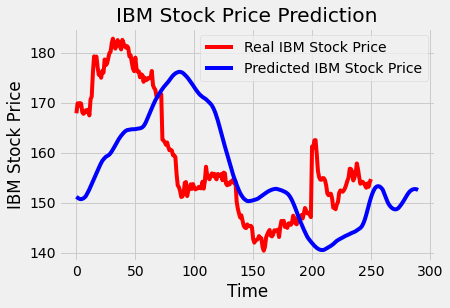

In [ ]:
plot_predictions(test_set,predicted_stock_price)


In [ ]:
predicted_stock_price.shape

(291, 1)

In [ ]:
# AVALIANDO O MODELO DE LSTM CRIADO

return_rmse(test_set,predicted_stock_price[:len(test_set)])

O resultado de RMSE é 13.217185474506893.


# GRU

A unidade GRU não precisa usar uma unidade de memória para controlar o fluxo de informações como a unidade LSTM. Ele pode usar diretamente todos os estados ocultos sem nenhum controle. 

As GRUs têm menos parâmetros e, portanto, podem treinar um pouco mais rápido ou precisar de menos dados para generalizar. Porém, se utilizarmos um conjunto de dados grandes, os LSTMs com maior expressividade, levando a melhores resultados.



# Arquitetura da GRU

In [ ]:
regressorGRU = Sequential()

# Primeira camada da GRU sem o regularizador Dropout
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))

"""Sequência de 3 novas camadas de GRU"""

# Camada 2
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))

# Camada 3
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))

# Camada 4
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))

# Camada de saída
regressorGRU.add(Dense(units=1))

# Compilando a Rede Neural
regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')

# Ajustando a base de treino
regressorGRU.fit(X_train,y_train,epochs=50,batch_size=150)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/50
19/19 [==============================] - 7s 29ms/step - loss: 0.1196
Epoch 2/50
19/19 [==============================] - 1s 30ms/step - loss: 0.0400
Epoch 3/50
19/19 [==============================] - 1s 30ms/step - loss: 0.0108
Epoch 4/50
19/19 [==============================] - 1s 29ms/step - loss: 0.0046
Epoch 5/50
19/19 [==============================] - 1s 28ms/step - loss: 0.0041
Epoch 6/50
19/19 [==============================] - 1s 29ms/step - loss: 0.0038
Epoch 7/50
19/19 [==============================] - 1s 29ms/step - loss: 0.0039
Epoch 8/50
19/19 [==============================] - 1s 29ms/step - loss: 0.0034
Epoch 9/50
19/19 [==============================] - 1s 29ms/step - loss: 0.0032
Epoch 10/50
19/19 [==============================] - 1s 29ms/step - loss: 0.0031
Epoch 11/50
19/19 [==============================] - 1s 29ms/step - loss: 0.0030
Epoch 12/50
19/19 [==============================] - 1s 30ms/step - loss: 0.0030
Epoch 13/50
19/19 [==================

OBS: A versão atual da GRU utiliza 100 unidade ao invés de 50 como utilizado nesse notebook.

## Prevendo os Preços

In [ ]:
X_test = []

for i in range(20,311):
    X_test.append(inputs[i-20:i,0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

## Visualizando os Resultados

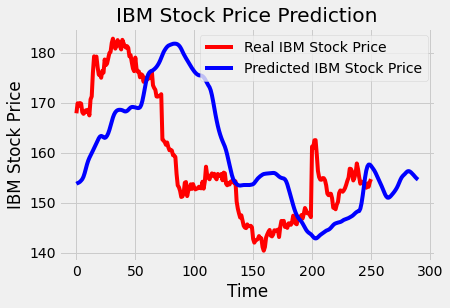

In [ ]:
plot_predictions(test_set,GRU_predicted_stock_price)

In [ ]:
# AVALIANDO O MODELO DE GRU CRIADO
return_rmse(test_set,GRU_predicted_stock_price[:len(test_set)])

O resultado de RMSE é 12.981192144842636.


# Geração de Sequência com 60 primeiros valores

Geração de uma sequência usando apenas 60 valores iniciais, em vez de usar os últimos 60 valores para cada nova previsão. 

* Os modelos acima fazem uso do conjunto de testes para que usar os últimos 60 valores reais para prever o novo valor. 

É por isso que o erro é tão baixo. Modelos fortes também podem trazer resultados semelhantes, como os modelos acima, para seqüências, mas exigem mais do que apenas dados com valores anteriores. 

* No caso de ações, precisamos conhecer os sentimentos do mercado, o movimento de outras ações e muito mais. 

Portanto, não espere uma plotagem remotamente precisa. O erro será ótimo e o melhor que posso fazer é gerar uma tendência semelhante ao conjunto de testes.

Utilizando um novo modelo de sequência com a GRU e LSTM para novas previsões utilizando apenas os 60 valores iniciais

## GRU 

In [ ]:
# Preparando a sequência de dados

initial_sequence = X_train[2700,:]

sequence = []

for i in range(251):
    
    new_prediction = regressorGRU.predict(initial_sequence.reshape(initial_sequence.shape[1],initial_sequence.shape[0],1))
    initial_sequence = initial_sequence[1:]
    initial_sequence = np.append(initial_sequence,new_prediction,axis=0)
    sequence.append(new_prediction)

sequence = sc.inverse_transform(np.array(sequence).reshape(251,1))

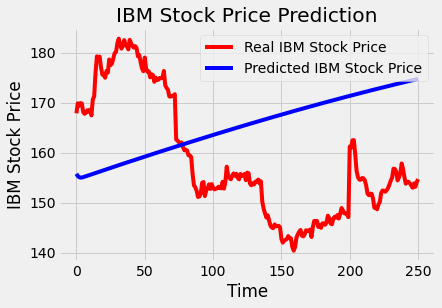

In [ ]:
# Visualizando a Sequência

plot_predictions(test_set,sequence)

In [ ]:
# AVALIANDO O RESULTADO DA SEQUENCIA COM GRU

return_rmse(test_set,sequence)

O resultado de RMSE é 18.356690210771415.


## LSTM

In [ ]:
# Preparando a sequência de dados

initial_sequence = X_train[2708,:]

sequence = []

for i in range(251):
    
    new_prediction = regressor.predict(initial_sequence.reshape(initial_sequence.shape[1],initial_sequence.shape[0],1))
    initial_sequence = initial_sequence[1:]
    initial_sequence = np.append(initial_sequence,new_prediction,axis=0)
    sequence.append(new_prediction)

sequence = sc.inverse_transform(np.array(sequence).reshape(251,1))

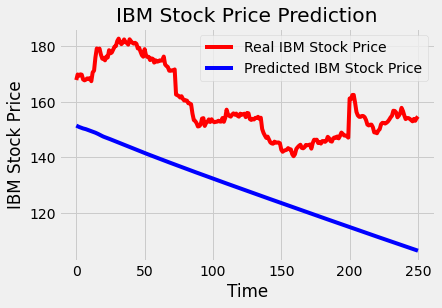

In [ ]:
# Visualizando a Sequência

plot_predictions(test_set,sequence)

In [ ]:
# AVALIANDO O RESULTADO DA SEQUENCIA COM LSTM

return_rmse(test_set,sequence)

O resultado de RMSE é 31.544399964951392.
